Example 3D plot combining vertical profiles and horizontal sections.

In [80]:
import os
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
%matplotlib inline

# Files and directories

Maybe taking a file available on the public thredds would be better.<br>
Depends if that works from IMEDEA.

In [82]:
coastdir = './coastline_cartex_f.txt'
ctdfile = ('http://thredds.priv.socib.es/thredds/dodsC/research_vessel/ctd/'
           'socib_rv-scb_sbe9002/L1/2014/dep0007_socib-rv_scb-sbe9002_L1_2014-05-25.nc')
wmopfile = ('http://thredds.socib.es/thredds/dodsC/operational_models/'
            'oceanographical/hydrodynamics/wmop/2014/05/roms_wmop_20140526.nc')

## Functions for loading the data

In [83]:
def alborex_load_ctd(ctdfile):
    with netCDF4.Dataset(ctdfile, 'r') as nc:
        lon = nc.variables['LON'][:]
        lat = nc.variables['LAT'][:]
        depth = nc.variables['DEPTH'][:]
        temp = nc.variables['WTR_TEM_01'][:]
        chloro = nc.variables['CHLO'][:]
        chloro = np.ma.masked_where(np.isnan(chloro), chloro)
    return lon, lat, depth, temp, chloro

In [84]:
def alborex_load_coast(coastdir, coastfile, valex):
    lon, lat = np.loadtxt(os.path.join(coastdir, coastfile), usecols=(0, 1), unpack=True)
    lon[lon == valex] = np.nan
    lat[lat == valex] = np.nan
    return lon, lat

In [85]:
def load_wmop_mean(wmopfile, coordinates):
    with netCDF4.Dataset(wmopfile) as nc:
        lon = nc.variables['lon_rho'][:]
        lat = nc.variables['lat_rho'][:]
        goodlon = np.where( (lon<= coordinates[1]) & (lon>= coordinates[0]))[0]
        goodlat = np.where( (lat<= coordinates[3]) & (lat>= coordinates[2]))[0]
        lon = lon[goodlon]
        lat = lat[goodlat]
        temp = np.mean(nc.variables['temp'][:, goodlat, goodlon], axis=0)
    return lon, lat, temp

In [86]:
def change_wall_prop(ax, coordinates, depths, angles):
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_xaxis.gridlines.set_linestyles(':')
    ax.w_yaxis.gridlines.set_linestyles(':')
    ax.w_zaxis.gridlines.set_linestyles(':')
    ax.view_init(angles[0], angles[1])
    ax.set_xlim(coordinates[0], coordinates[1])
    ax.set_ylim(coordinates[2], coordinates[3])
    ax.set_zlim(depths[0], depths[1])
    ax.set_zlabel('\nDepth (m)')

    ax.set_zticks(np.arange(depths[0], depths[1] + 10, depths[2]))
    ax.set_zticklabels(range(int(-depths[0]), -int(depths[1]) - 10, -int(depths[2])))

# Options for the plot

In [87]:
rcParams.update({'font.size': 22})
dlon, dlat = 1., 1.
coordinates = [-0.85, -0.25, 36.71, 37.19]
depthmin = 0.0
depthmax = 300.0

valex = 999
cmap = plt.cm.YlGnBu
tempCTDmin, tempCTDmax = 13., 19.
boundsCTDtemp = np.arange(tempCTDmin, tempCTDmax, 1.)
normCTDtemp = colors.Normalize(vmin=tempCTDmin, vmax=tempCTDmax)
cmapCTDtemp = plt.cm.spectral

depths = np.array((-600, 0, 100))
angles = np.array((55, -40))
props = dict(boxstyle='round', facecolor='white', alpha=0.99)

# Load data

## Coastline, CTD profiles and model output

In [72]:
loncoast, latcoast = alborex_load_coast(coastdir, coastfile, valex)
lonCTD, latCTD, depthCTD, tempCTD, chloroCTD = alborex_load_ctd(ctdfile)
lonWMOP, latWMOP, tempWMOP = load_wmop_mean(wmopfile, coordinates)

## Regrid coordinates (needed for the contour3D)

In [89]:
lonWMOP, latWMOP = np.meshgrid(lonWMOP, latWMOP)

# Make the plot

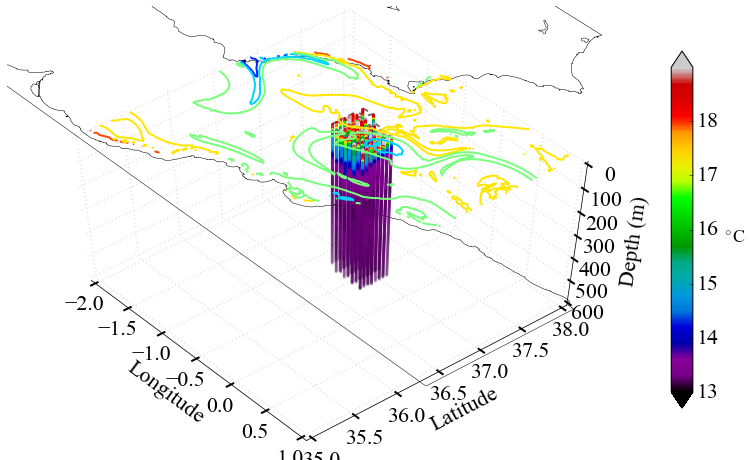

In [76]:
fig = plt.figure(num=None, figsize=(14, 8))
ax = fig.gca(projection='3d')
fig.patch.set_facecolor('white')

ndepth = depthCTD.shape[1]
for p in range(0, depthCTD.shape[0]):
    scat3D = ax.scatter(lonCTD[p] * np.ones(ndepth), latCTD[p] * np.ones(ndepth),
                        -depthCTD[p, :], s=10, c=tempCTD[p, :], marker='o',
                        edgecolor='none', norm=normCTDtemp,
                        cmap=cmapCTDtemp, zorder=4)

# Plot the surface CTD track
ax.plot3D(lonCTD,latCTD,0,'--',color="0.45")

# Add the colorbar
cbar = fig.colorbar(scat3D, cmap=cmap, orientation='vertical', pad=0.05,
                    aspect=15, shrink=0.8, norm=normCTDtemp, extend='both')
cbar.set_label('$^{\circ}$C', rotation=0, ha='left', fontsize=18)
cbar.set_clim(tempCTDmin, tempCTDmax)
cbar.set_ticks(boundsCTDtemp)

# Plot coastline
ax.plot3D(loncoast, latcoast, 0, color='k', lw=0.5, zorder=6)
plt.xlabel('\nLongitude')
plt.ylabel('\nLatitude')

# Add contours from WMOP surface temperature
ax.contour3D(lonWMOP, latWMOP, tempWMOP)

# Change wall properties
change_wall_prop(ax, coordinates, depths, angles)

plt.show()
plt.close()